# <font color="#003660">Applied Machine Learning for Text Analysis (M.184.5331)</font>


# <font color="#003660">Session 1: Introduction to Natural Language Processing</font>

# <font color="#003660">Notebook 4: MLP with Word Embeddings as Features</font>

<center><br><img width=256 src="https://raw.githubusercontent.com/olivermueller/aml4ta-2021/main/resources/dag.png"/><br></center>

<p>
<center>
<div>
    <font color="#085986"><b>By the end of this lesson, you ...</b><br><br>
        ... are able to train a neural network with word embeddings as features.
    </font>
</div>
</center>
</p>

# Multi Layer Perceptron (MLP)

The diagram and equation below illustrate the architecture of a simple feedforward neural network, also known as a multi-layer perceptron (MLP) (James et al. 2023). The network consists of an input layer, one or more hidden layers, and an output layer. Each layer is fully connected to the next layer. The input layer has as many neurons as we have features and the output layer has one neuron in the case of regression and as many neurons as we have classes in the classification case. The number of neurons in the hidden layer is a hyperparameter that can be tuned by the analyst. The same applies to the number of hidden layers.

<center><img width=512 src="https://raw.githubusercontent.com/olivermueller/amlta-2024/main/Session_02/mlp.png"/></center>

# Import packages

As always, we first need to load a number of required Python packages:
- `pandas` provides high-performance, easy-to-use data structures and data analysis tools.
- `numpy` is a library adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- `sklearn` is a free software machine learning library for the Python programming language.
- `tensorflow` is an end-to-end open source platform for machine learning, especially deep learning.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn import metrics
import matplotlib.pyplot as plt

Check if we are running on GPU.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load documents

Load wine reviews (Source: https://www.kaggle.com/datasets/zynicide/wine-reviews) from a csv file.

In [3]:
corpus = pd.read_csv("https://raw.githubusercontent.com/olivermueller/amlta-2025/main/Session_01/winemag-data-130k-v2.csv")

Split data into three sets: training, validation, and test.

In [4]:
training = corpus.iloc[0:80000,].sample(n=10000) # sample to speed up training
validation = corpus.iloc[80000:100000,]
test = corpus.iloc[100000:,]

For each dataset, store features and targets in separate variables

In [5]:
train_corpus_features = training[["description"]]
train_corpus_target = training[["points"]]
val_corpus_features = validation[["description"]]
val_corpus_target = validation[["points"]]
test_corpus_features = test[["description"]]
test_corpus_target = test[["points"]]

Create [TensorFlow `Datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from the Pandas dataframes. The use of TensorFlow Datasets follows a common pattern:

1.   Create a dataset from raw data (e.g., a Pandas dataframe, a CSV file, multiple text files).
2.   Apply transformations to preprocess the data in the dataset (e.g., tokenize and vectorize the texts).
3. Iterate over the dataset and process its elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

Here, we use the `from_tensor_slices` constructor to create datasets from dataframes.

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train_corpus_features.values, tf.string),
                                               tf.cast(train_corpus_target.values, tf.int32)))

val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(val_corpus_features.values, tf.string),
                                             tf.cast(val_corpus_target.values, tf.int32)))

test_ds = tf.data.Dataset.from_tensor_slices((tf.cast(test_corpus_features.values, tf.string),
                                              tf.cast(test_corpus_target.values, tf.int32)))

2025-10-28 08:58:20.588067: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-28 08:58:20.588100: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-28 08:58:20.588108: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-28 08:58:20.588286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-28 08:58:20.588434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Display some stats and examples from the created datasets.

In [7]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1,)
inputs.dtype: <dtype: 'string'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(b'This is showing light black cherry fruit, forward and moderately chewy. Other hints of black fruits and coffee grounds add some interest, with smoke and pepper filling out the finish.', shape=(), dtype=string)
targets[0]: tf.Tensor(86, shape=(), dtype=int32)


# Vectorize documents

We will now use [TensorFlow's `TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) function to transform raw texts into numerical vectors. **Instead of counting word appearances (like in the BOW model), we simply map words to integers (`output_mode = 'int'`) this time.** To get document representation of a fixed length, we limit the length of documents to 100 tokens (longer documents will be truncated, shorter documents will be padded with zeros).

In [8]:
max_tokens = 10000
max_length = 100

text_vectorization = TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

Some apects of the `TextVectorization` function (e.g., the size and contents of the vocabulary) have to be fit using training data, which can be done with the `adapt` function (which can only be applied to the features (x) of the dataset). 

In [9]:
train_ds_features_only = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_features_only)

2025-10-28 08:58:41.516279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Show the vocabulary that our vectorizer knows after being fit to the training data.

In [10]:
text_vectorization.get_vocabulary()[0:10]

['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine']

Next, we apply our `text_vectorization` function to all three datasets.

In [11]:
vectorized_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

Show results.

In [12]:
for inputs, targets in vectorized_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1, 100)
inputs.dtype: <dtype: 'int64'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(
[   7    8  226   59   29   27   15  341    2  933  350  415  159    5
   29   45    2  186 2280  422   73  794    6  255    2   70 1124   86
    3   21    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
targets[0]: tf.Tensor(86, shape=(), dtype=int32)


# Train model

We are now ready to specify a neural network and feed it with the vectroized datasets. For convenience, we define a custome function `get_model` which defines the network architecture, creates a model from it, and compiles this model (by defining, e.g., an otpimizer and loss function). Note that we have to somehow reduce the dimensionality of the output of the embedding layer (sequence_length*embedding_dim). Here, we simply perform a global average pooling (i.e., average each element of the embedding vector over all tokens).

In [13]:
def get_model(hidden_dim=32):
    inputs = keras.Input(shape=(max_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=300, mask_zero=True)(inputs)
    hidden1 = layers.GlobalAveragePooling1D()(embedded)
    hidden2 = layers.Dense(hidden_dim, activation = "relu")(hidden1)
    outputs = layers.Dense(1, activation = "linear")(hidden2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer = tf.optimizers.Adam(),
                  loss = "mean_absolute_error",
                  metrics = ["mean_absolute_error"])
    return model

Instantiate model and show it's architecture.

In [14]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3000000   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3009665 (11.48 MB)
Trainable params: 3009665 (11.48 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

Fit model on training data and save best model to disk. We use the validation set to monitor how the performance of the model evolves during training.

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint("mlp.keras", save_best_only=True)]

history = model.fit(vectorized_train_ds.cache(),
          validation_data = vectorized_val_ds.cache(),
          epochs = 3,
          batch_size = 128,
          callbacks = callbacks)

Epoch 1/3


2025-10-28 09:05:56.076045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_2.


10000/10000 [==============================] - 169s 17ms/step - loss: 6.2622 - mean_absolute_error: 6.2622 - val_loss: 4.0730 - val_mean_absolute_error: 4.0730
Epoch 2/3
10000/10000 [==============================] - 165s 16ms/step - loss: 3.2723 - mean_absolute_error: 3.2723 - val_loss: 3.2233 - val_mean_absolute_error: 3.2233
Epoch 3/3
10000/10000 [==============================] - 163s 16ms/step - loss: 2.7349 - mean_absolute_error: 2.7349 - val_loss: 3.0449 - val_mean_absolute_error: 3.0449


Plot the learning process.

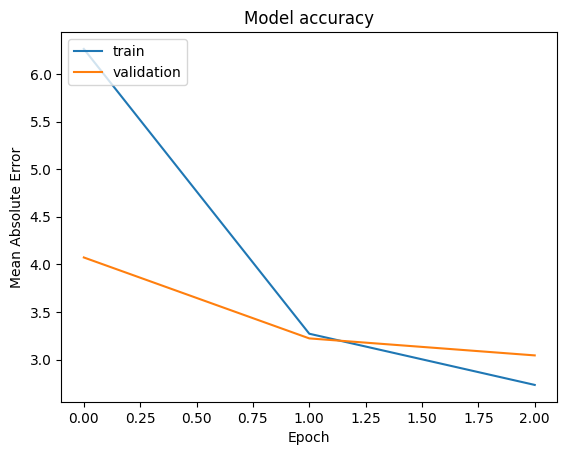

In [16]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make predictions

Before calculating the predictions of our model, let's first create a simple benchmark (i.e., always predicting the mean points of the training set).

In [17]:
print(metrics.mean_absolute_error(test_corpus_target, [train_corpus_target.mean()]*len(test_corpus_target)))

2.5335139468152548


Load best model from training phase.

In [18]:
model = keras.models.load_model("mlp.keras")

Make predictions on test set.

In [19]:
preds = model.predict(vectorized_test_ds)

29971/29971 [==============================] - 58s 2ms/step


Calculate accuracy metrics.

In [20]:
print(metrics.mean_absolute_error(test_corpus_target, preds))

3.075836181640625
